# Information Warfare
## Russia’s use of Twitter during the 2016 US Presidential Election
---

In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE

import plotly.io as pio
import plotly.express as px

from IPython.display import Image

## Import Data

In [2]:
embeddings_dataframe = pd.read_csv("./data/tweet-embeddings.csv")

embeddings_matrix = embeddings_dataframe.iloc[:, 2:].values

embeddings_dataframe.head()

,author,account_category,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,10_GOP,RightTroll,-0.031191,0.072164,0.002935,0.176047,-0.024991,-0.028112,-0.385420,-0.100027,...,0.597388,0.265694,0.522910,0.169615,0.527276,0.239573,-0.165664,-0.148989,-0.462181,-0.122737
1,4MYSQUAD,LeftTroll,-1.899873,-0.664060,-0.215870,-0.597210,0.074473,1.152682,-1.000418,0.191990,...,0.308547,0.008474,-0.090997,-1.742840,-0.121621,-0.478339,-0.019910,-0.860714,-1.089115,-0.436681
2,AANTIRACIST,LeftTroll,-0.191448,-0.309544,-0.158824,0.081305,-0.258105,0.595419,-0.810485,-0.153275,...,0.546358,-0.080009,0.459926,-0.328973,0.118801,-0.017565,-0.404157,-0.850216,-1.134679,-0.285619
3,ABIGAILSSILK,HashtagGamer,-0.476657,-0.871102,0.758561,-0.592526,-0.083075,-0.065238,0.236095,0.929137,...,-0.602666,-0.004763,0.515386,-1.170064,0.329660,1.042544,-0.831178,-0.124889,0.124674,-0.888706
4,ABIISSROSB,RightTroll,-0.301149,-0.627965,0.240993,0.127255,0.357296,-0.519391,-1.024643,-0.335651,...,0.901796,0.561848,1.116904,0.144136,0.893491,0.389437,0.020548,-0.305099,-0.299356,-0.400765


## Dimension Reduction (t-SNE) and Visualization

In [3]:
tsne_35 = TSNE(n_components=2, perplexity=35, verbose=0 , n_iter = 1000)\
                .fit_transform(embeddings_matrix)

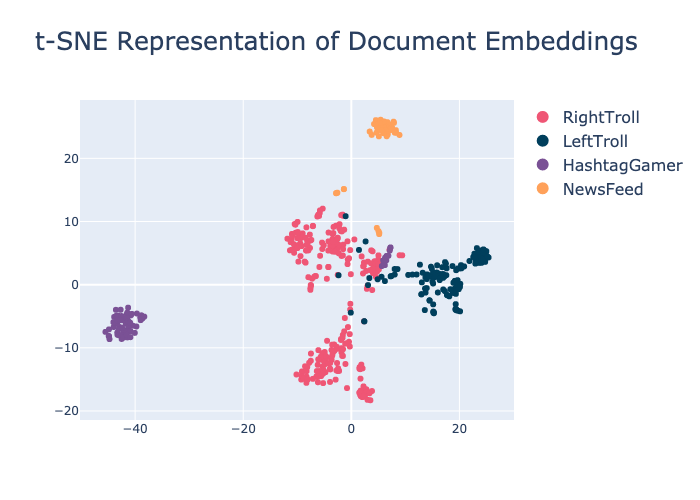

In [4]:
color_mapping = {'LeftTroll':'#003f5c', 'RightTroll': '#ef5675', 'HashtagGamer': '#7a5195', 'Newsfeed': '#ffa600'}

fig = px.scatter(x=tsne_35[:,0], 
                 y=tsne_35[:,1], 
                 color=embeddings_dataframe.account_category,
                 color_discrete_map=color_mapping,
                 title="t-SNE Representation of Document Embeddings")

fig.update_layout(yaxis={'title':None}, 
                  xaxis={'title':None}, 
                  legend_title_text=None,
                  legend={'font':{'size':16}, 'itemsizing':'constant'},
                  title={'font':{'size':25}})

#write to disk 
fig.write_image("./img/tsne-docvecs.png")

# generate static plot
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# Logistic Regression

In [5]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_dataframe.iloc[:,2:], 
                                                    embeddings_dataframe.account_category,
                                                    stratify=embeddings_dataframe.account_category,
                                                    test_size=0.5)

In [6]:
#embeddings_dataframe.account_category.value_counts()

In [7]:
#grid_logreg.get_params().keys()

logreg = OneVsRestClassifier(LogisticRegression(solver = 'liblinear'))

params_logreg = {'estimator__C': np.arange(.1, 1, .2)}

grid_logreg = GridSearchCV(estimator=logreg,
                          param_grid=params_logreg,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

grid_logreg.fit(X_train, y_train)

print("best score", grid_logreg.best_score_, "\n\n", "best_params", grid_logreg.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.992 

 best_params {'estimator__C': 0.30000000000000004}


In [8]:
best_model = grid_logreg.best_estimator_

y_pred = best_model.predict(X_test)

print("Accuracy Score: ",accuracy_score(y_test, y_pred), "\n", "\n")
print(classification_report(y_test, y_pred))

Accuracy Score:  0.9598393574297188 
 

              precision    recall  f1-score   support

HashtagGamer       1.00      0.97      0.99        35
   LeftTroll       0.98      0.89      0.93        63
    NewsFeed       1.00      0.96      0.98        23
  RightTroll       0.93      0.99      0.96       128

    accuracy                           0.96       249
   macro avg       0.98      0.95      0.96       249
weighted avg       0.96      0.96      0.96       249



In [9]:
with open("./models/logreg.pkl", 'wb') as file:
    pickle.dump(best_model, file)